Restaurants Recommendations
==============
This is a recomendation system for restaurants using collaborative filtering (CF). There are two primary approaches to CF: neighborhood (similarities between items or users) and latent factor model (hidden factors through which users and items are transformed into the same space). [reference](https://github.com/cs109/content/blob/master/HW4_solutions.ipynb)

The outline of this project is as follows:
- Create a database of item-item similarities. 
- Predict the rating that a user will give an item they have never seen before. 
- Implement a factor-based CF recommendar using a Bayesian model. 

About 7000 reviews from the complete data set with 150,000 reviews will be used. This subset is limited to all the users who had rated more than 60 restaurants, and all the businesses which had greater than 150 reviews.   

In [5]:
%matplotlib inline
from collections import defaultdict
import json

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl

#colorbrewer2 Dark2 qualitative color table
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'white'
rcParams['patch.facecolor'] = dark2_colors[0]
rcParams['font.family'] = 'StixGeneral'
        
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

plt.style.use('ggplot')

Description of the data set
------------------
The data set has been extracted from the Yelp Phoenix restaurants dataset. 

In [2]:
fulldf=pd.read_csv('bigdf.csv')
fulldf.head(2)

,user_id,business_id,date,review_id,stars,usefulvotes_review,user_name,categories,biz_name,latitude,longitude,business_avg,business_review_count,user_avg,user_review_count
0,rLtl8ZkDX5vH5nAx9C3q5Q,9yKzy9PApeiPPOUJEtnvkg,2011-01-26 00:00:00,fWKvX83p0-ka4JS3dc6E5A,5,5,Jason,"[Breakfast & Brunch, Restaurants]",Morning Glory Cafe,33.390792,-112.012504,3.87156,109,3.796954,197
1,SBbftLzfYYKItOMFwOTIJg,9yKzy9PApeiPPOUJEtnvkg,2008-05-04 00:00:00,DASdFe-g0BgfN9J2tanStg,5,1,Jennifer,"[Breakfast & Brunch, Restaurants]",Morning Glory Cafe,33.390792,-112.012504,3.87156,109,3.473684,57


The data frame is a frame of reviews.

- The information for the reviews themselves:
stars': (star rating, integer 1-5), 'date': (date, formatted like '2011-04-19'), 'review_id': (unique id for the review).

- The information on the business sized: 
'business_id': (a unique identifier for this business), 'biz_name': (the full business name), 'latitude': (latitude), 'longitude': (longitude), 'business_review_count': (review count for the restaurant[this is a repeated field for all reviews of the restaurant]), 'categories': [(localized category names)], 'business_avg': (average stars over all users reviews for business[this is a repeated field for all reviews of the restaurant]).

- The information about users:
'user_id': (unique user identifier), 'user_name': (first name, last initial, like 'Matt J.'), 'user_review_count': (count of restaurants reviewed by user[this is a repeated field for all reviews by the user]), 'user_avg': (floating point average of users reviews over all businesses, like 4.31[this is a repeated field for all reviews by the user]).


Find similarity
---------
The baseline estimate of a restaurant $ \hat{Y_{um}}$ is equal to the total average rating of all restaurants, plus the average rating of this paricular restaurant $m$ above total average rating, plus the average rating of this particular user $u$ above total average rating. For example, we assume the average rating of all restaurants at Princeton is 3.5. Tomo Sushi is better than an average restaurant by 0.5 above the average. However, Woodrow Wilson tends to rate 0.2 stars below the average. Then the baseline estimate for the recommendation for Tomo Sushi for Woodrow Wilson is $3.5+0.5-0.2=3.8$.

We can estimate unknow rating $Y_{um}$ for user $u$ or business $m$ as:
$$ \hat{Y_{um}} = \hat Y_{um}^{baseline}\, + \,\frac{\sum\limits_{j \in S^{k}(m)} s_{mj} ( Y_{uj} - \hat Y_{uj}^{baseline} )}{\sum\limits_{j \in S^{k}(m)} s_{mj} } $$

where $S^{k}(m)$ is the $k$ neighbor items (which have been rated by user $u$) of item $m$, $s_{mj}$ is the similarity measured via **Pearson's coefficient**.

1. Global recommender
====
Calculate the similarity betweeen items and rank the nearest neighbors of an item by this similarity based on the 'global' assumption that every user perceives the similarity between restaurants in the same way.  

1.1 Exploratory data analysis
------

In [15]:
print "Number of reviews",fulldf.shape[0]
print "Number of users",fulldf.user_id.unique().shape[0]
print "Number of business", fulldf.business_id.unique().shape[0]

Number of reviews 149319
Number of users 34789
Number of business 4503


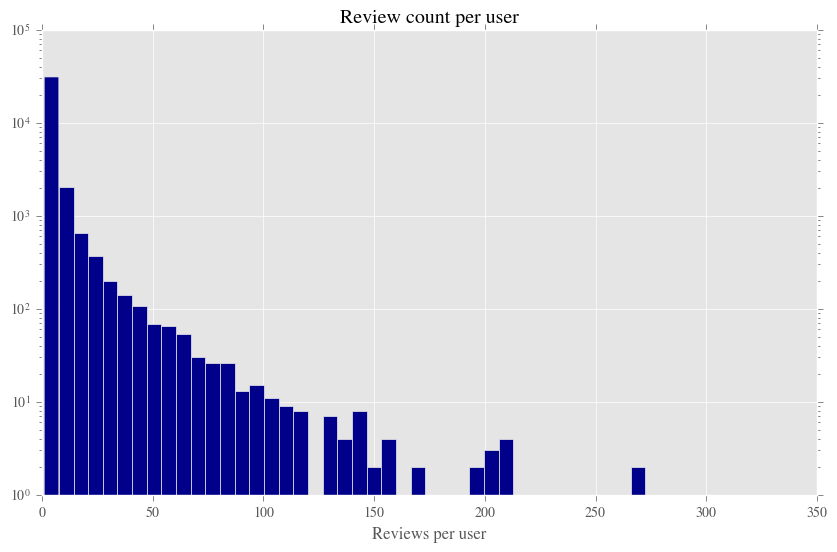

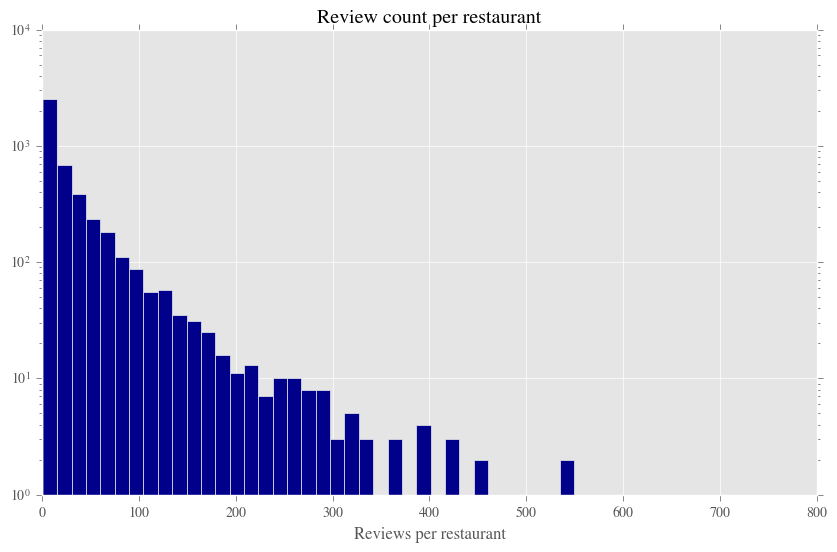

In [30]:
plt.figure()
# Visualize number of reviews per user 
urc=fulldf.groupby('user_id').review_id.count()
ax=urc.hist(bins=50, log=True, color='DarkBlue')
plt.xlabel("Reviews per user")
plt.title("Review count per user")

# Visualize number of reviews per restaurant
plt.figure()
brc=fulldf.groupby('business_id').review_id.count()
ax=brc.hist(bins=50, log=True, color='DarkBlue')
plt.xlabel("Reviews per restaurant")
plt.title("Review count per restaurant")

Average rating of reviews  3.74141268023


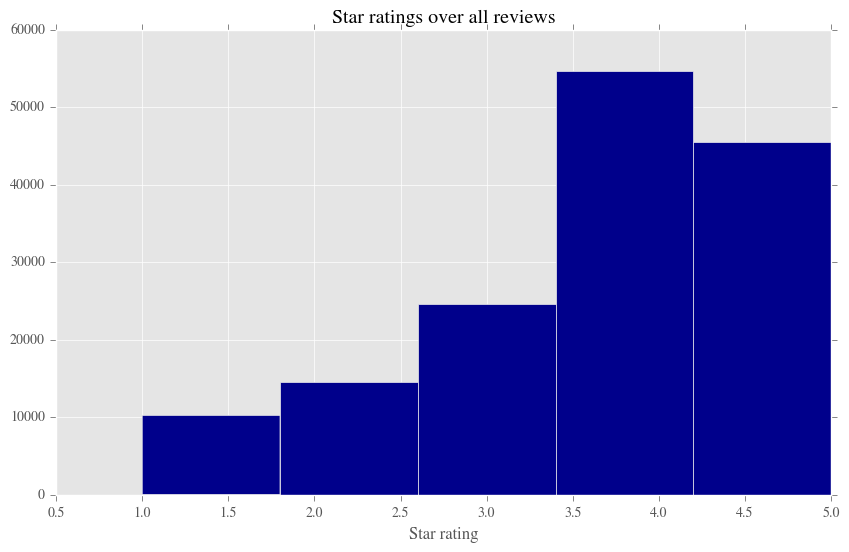

In [27]:
print "Average rating of reviews ", fulldf.stars.mean()
ax=fulldf.stars.hist(bins=5, color='DarkBlue')
plt.xlabel("Star rating")
plt.title("Star ratings over all reviews")

In [13]:
def Recompute_Frame(ldf):
    """
    takes a dataframe ldf, makes a copy of it, and returns the copy
    with all averages and review counts recomputed
    this is used when a frame is subsetted.
    """
    ldfu=ldf.groupby('user_id')
    ldfb=ldf.groupby('business_id')
    user_avg=ldfu.stars.mean()
    user_review_count=ldfu.review_id.count()
    business_avg=ldfb.stars.mean()
    business_review_count=ldfb.review_id.count()
    nldf=ldf.copy()
    # new features
    nldf.set_index(['business_id'], inplace=True)
    nldf['business_avg']=business_avg
    nldf['business_review_count']=business_review_count
    nldf.reset_index(inplace=True)
    nldf.set_index(['user_id'], inplace=True)
    nldf['user_avg']=user_avg
    nldf['user_review_count']=user_review_count
    nldf.reset_index(inplace=True)
    return nldf

Now create a smaller data set with the following criteria: those businesses with more than 150 reviews and those users with more than 60 reviews. Then use the function `recompute_frame` to recalculate the averages and counts. 

In [14]:
smalldftemp=fulldf[(fulldf.user_review_count > 60) & (fulldf.business_review_count > 150)]
smalldf=Recompute_Frame(smalldftemp)

Total number of reviews 6165
Users in this set 240
Restaurants in this set 240


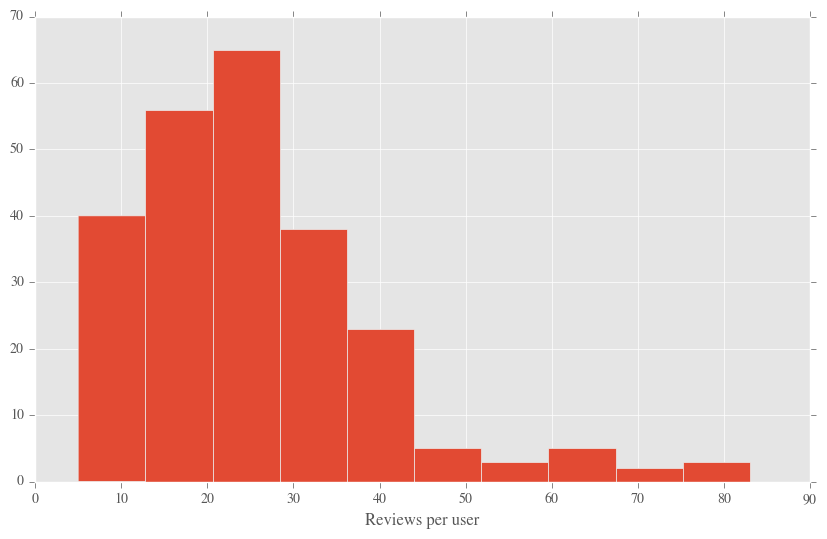

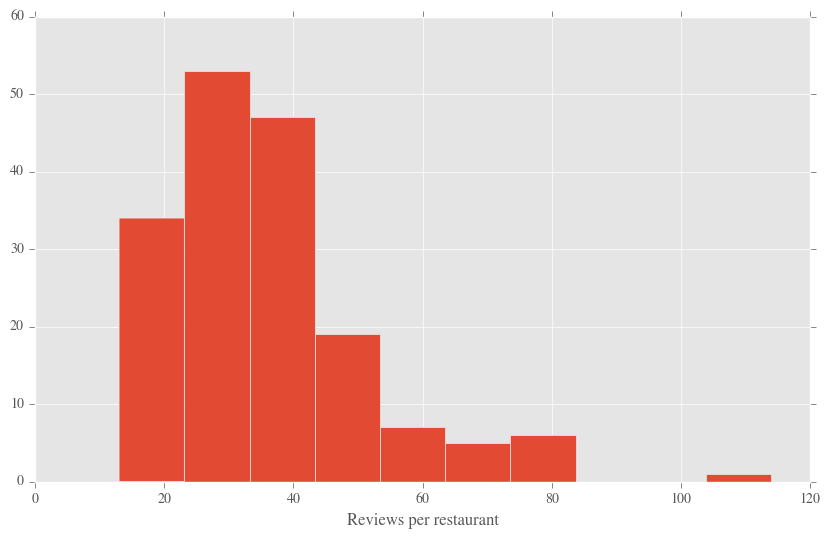

In [18]:
print 'Total number of reviews', smalldf.shape[0]
print 'Users in this set', smalldf.user_id.unique().shape[0]
print 'Restaurants in this set', smalldf.user_id.unique().shape[0]

# Visualize number of reviews per user and per restaurant
plt.figure()
ax=smalldf.groupby('user_id').review_id.count().hist()
plt.xlabel("Reviews per user")
plt.figure()
ax=smalldf.groupby('business_id').review_id.count().hist()
plt.xlabel("Reviews per restaurant")

Average rating 3.86763990268


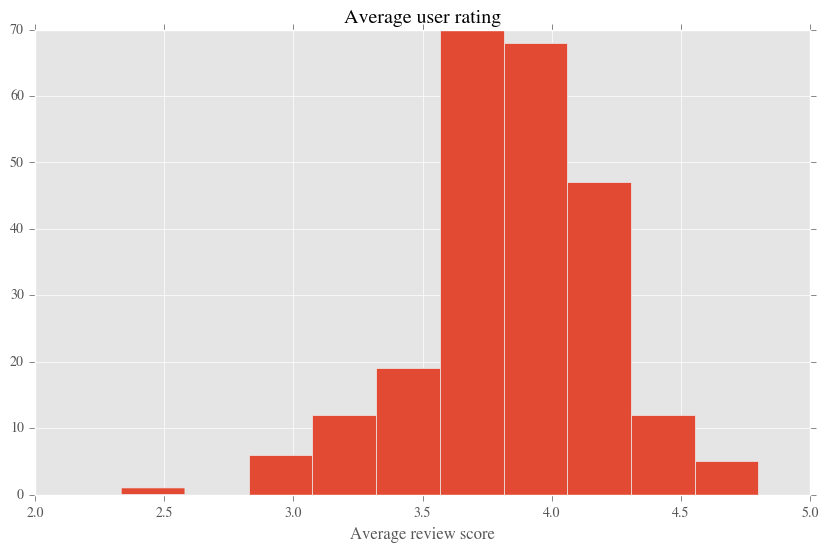

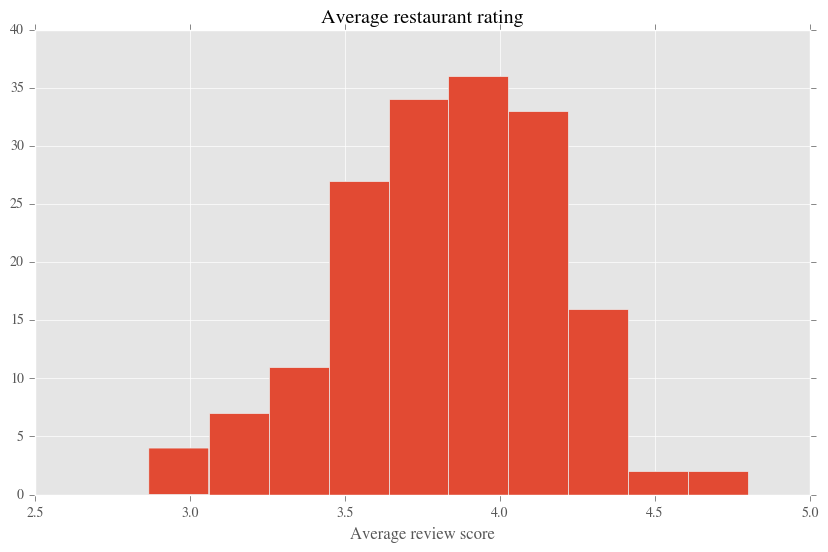

In [22]:
plt.figure()
avg_ratings_by_user=smalldf.groupby('user_id').stars.mean()
ax=avg_ratings_by_user.hist()
plt.xlabel("Average review score")
plt.title("Average user rating")

plt.figure()
avg_ratings_by_rest=smalldf.groupby('business_id').stars.mean()
ax=avg_ratings_by_rest.hist()
plt.xlabel("Average review score")
plt.title("Average restaurant rating")

print "Average rating", smalldf.stars.mean()

1.2 The common user support
---------
For each pair of restaurants, find the number of people who reviewed both. If the common support is low, the similarity is less believable.  

Mean support is 6.84679722562


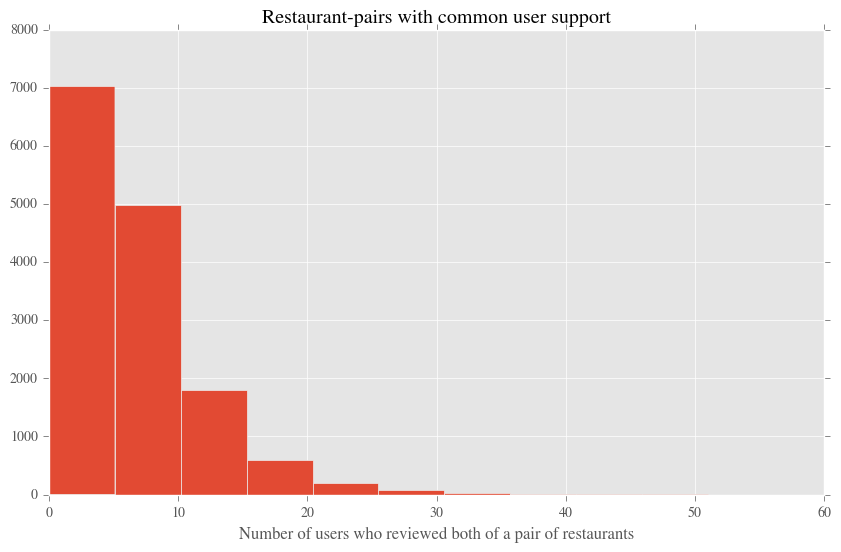

In [25]:
restaurants=smalldf.business_id.unique()
supports=[]
for i, restA in enumerate(restaurants):
    for j, restB in enumerate(restaurants):
        if i < j:
            restA_reviewers = smalldf[smalldf.business_id==restA].user_id.unique()
            restB_reviewers = smalldf[smalldf.business_id==restB].user_id.unique()
            common_reviewers = set(restA_reviewers).intersection(restB_reviewers)
            supports.append(len(common_reviewers)) 
print "Mean support is", np.mean(supports) # average number of common support users
plt.hist(supports)
plt.xlabel('Number of users who reviewed both of a pair of restaurants')
plt.title('Restaurant-pairs with common user support')

Even though we chosa subset of the dataframe in which every restaurant had 150 reviews and every user had atleast made 60, the common support of most pairs of restaurants is really low, indeed less than 10.

1.3 Calculating similarity
------------
We need to subtract the average rating of the user from the actual rating of the restaurants in computing the similarity of two restaurants, using the function `Pearson_Sim` defined below. This makes the ratings by two different users comparable. 

The similarity is set to 0 if there is no common support (users who rated both restaurants). 

In [33]:
from scipy.stats.stats import pearsonr
def Pearson_Sim(restA_rev, restB_rev, n_common):
    """
    Given a subframe of restaurant 1 reviews and a subframe of restaurant 2 reviews,
    where the reviewers are those who have reviewed both restaurants, return 
    the pearson correlation coefficient between the user average subtracted ratings.
    The case for zero common reviewers is handled separately. Its
    ok to return a NaN if any of the individual variances are 0.
    """
    if n_common==0:
        rho=0.
    else:
        diffA=restA_rev['stars']-restA_rev['user_avg']
        diffB=restB_rev['stars']-restB_rev['user_avg']
        rho=pearsonr(diffA, diffB)[0]
    return rho

The function `Get_Restaurant_Rev` defined below takes a restaurant `business_id` and a set of users, and returns the reviews of that restaurant by those users. 

In [37]:
def Get_Restaurant_Rev(restaurant_id, df, set_of_users):
    """
    Given a restaurant id and a set of reviewrs, return the sub-dataframe of their reviews.
    """
    reviews=df[(df['business_id']==restaurant_id) & (df['user_id'].isin(set_of_users))]
    return reviews[reviews['user_id'].duplicated()==False]

Define a function `Calculate_Simularity` which operates as below:
1. For each of the two restaurants, get the set of reviewers who have reviewed the restaurant and compute the intersection of these two sets. Also compute the number of common reviewers n_common.
2. Use the function get_restaurant_reviews defined below to get the reviews for each restaurant as made by these common reviewers. Notice that get_restaurant_reviews returns a sub data frame of reviews.
3. Calculate the similarity using similarity_func which takes the two reviews dataframes from part 2 and the number of common reviewers n_common as arguments
4. Return the similarity and n_common in a tuple (sim, n_common). If the similarity is a NaN, set the similarity to 0.


In [40]:
def Calculate_Similarity(restA, restB, df, similarity_func):
    # find common reviewers
    restA_reviewers=df[df.business_id==restA].user_id.unique()
    restB_reviewers=df[df.business_id==restB].user_id.unique()
    common_reviewers=set(restA_reviewers).intersection(restB_reviewers)
    n_common=len(common_reviewers)
    # get common support reviews
    restA_reviews=Get_Restaurant_Rev(restA, df, common_reviewers)
    restB_reviews=Get_Restaurant_Rev(restB, df, common_reviewers)
    # use similarity_func to calculate similarity
    sim=similarity_func(restA_reviews, restB_reviews, n_common)
    if np.isnan(sim):
        return 0, n_common
    return sim, n_common

1.4 Making a database of similarities
---------------
The class `Database` is initialized in its constructor by taking as arguments a dataframe of reviews. The method `Populate_By_Calculating` iterates over every possible pair of business_id's in the dataframe and populates the database with similarities and common supports. It takes as arguments a function the similarity function `similarity_func` like `Pearson_Sim` (calculate_similarity then uses this to calculate the similarity). The `Get` method on the database can be used to retrieve the similarity for two business ids.

In [38]:
class Database:
    """A class representing a database of similarities and common supports"""
    
    def __init__(self,df):
        """The constructor, takes a reviews dataframe like smalldf as its argument"""
        database={}
        self.df=df
        self.uniquebizids={v:k for (k,v) in enumerate(df.business_id.unique())}
        keys=self.uniquebizids.keys()
        l_keys=len(keys)
        self.database_sim=np.zeros([l_keys,l_keys])
        self.database_sup=np.zeros([l_keys,l_keys], dtype=np.int)
        
    def Populate_By_Calculating(self, similarity_func):
        """
        A populator for every pair of restaurants in df. takes similarity_func like Pearson_Sim as argument.
        """
        items=self.uniquebizids.items()
        for b1, i1 in items:
            for b2, i2 in items:
                if i1<i2:
                    sim, nsup=Calculate_Similarity(b1, b2, self.df, similarity_func)
                    self.database_sim[i1][i2]=sim
                    self.database_sim[i2][i1]=sim
                    self.database_sup[i1][i2]=nsup
                    self.database_sup[i2][i1]=nsup
                elif i1==i2:
                    self.database_sim[i1][i1]=1.
                    nsup=self.df[self.df.business_id==b1].user_id.count()
                    self.database_sup[i1][i1]=nsup
                    
    def Get(self, b1, b2):
        """returns a tuple of similarity, common_support given two business_ids"""
        sim=self.database_sim[self.uniquebizids[b1]][self.uniquebizids[b2]]
        nsup=self.database_sup[self.uniquebizids[b1]][self.uniquebizids[b2]]
        return (sim, nsup)

Run `Database` and store the result in the global variable `db`. 

In [41]:
db=Database(smalldf)
db.Populate_By_Calculating(Pearson_Sim)

In [42]:
# Print out an example entry
db.Get("z3yFuLVrmH-3RJruPEMYKw", "zruUQvFySeXyEd7_rQixBg")

(0.39904554525734559, 7)

1.5 K-Nearest restaurants (in similarity)
------------